# The (nodal) Discontinous Galerkin Method for the linear advection equation

In [2]:
# This is a configuration step. Please run it before the simulation code!

# Imports etc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.rcsetup

import matplotlib.backends
plt.switch_backend("NbAgg")

# import of DG modules from same directory as the notebook
from gll import *
from lagrange import *
from lagrange1st import *
from legendre import *
from flux import *


# white instead of grey background
matplotlib.rcParams['figure.facecolor'] = 'w' 
plt.ion() # set interactive mode on

### The discretization of the advection equation

We want to solve the linear advection equation as the simplest (scalar) hyperbolic equation:

$$ \partial_t u + \mu \ \partial_x u=0$$

In the nodal approach we use Lagrange polynomials as basis functions $l_i$ to approximate the solution $u$ in an element $k$ at time $t$:
    $$ u_h^k(x,t)= \sum_{n=1}^{N_p} u_h^k(x_i,t) \cdot l_i(x) $$

with the Lagrange polynomials
$$l_i(x)=\prod_{\substack{0 \leq m \leq k \\m \neq i }}
 \frac{x-x_m}{x_i-x_m}=\frac{x-x_0}{x_i-x_0}\cdot .\ .\ . \cdot \frac{x-x_{k}}{x_i-x_{k}}$$

where $x_i$ are the Gauss-Labatto-Legendre points. 

The i-th Lagrange polynomial of Order $N$ at location x can caluclated by applying:

In [3]:
#function to calculate the i-th Lagrange polynomials of order N at location x

def lagrange(N,i,x):
  
    from gll import gll


    [xi, weights] =  gll(N) #xi= Gauss-Labatto-Legendre points between -1 and 1, weights=corresponding weights
    fac=1
    for j in range (-1,N): 
        if j != i:
            fac=fac*((x-xi[j+1])/(xi[i+1]-xi[j+1]))

    x=fac


    return x

We review the (local) semi-discrete scheme for the k-th element that we derived in the lecture:
$$  M^k \cdot \partial_{t} u_h^k(t) -  \mu \ (S^k)^T \cdot u_h^k(t)= -[(\mu \ u)^*(t) \ l_j^k(x)]_{x^{k}_l}^{x^{k}_r}$$

with the local mass matrix  $M^k$ and the local stiffness matrix $S^k$ with the entries:
$$ M^k_{i,j}= \int_{\tau_k} l_i(x) \ l_j(x) \ dx $$
and
$$ S^k_{i,j}= \int_{\tau_k} \partial_x l_i(x) \ l_j(x) \ dx $$
We'll see later how they are calculated.

### The numerical flux

Additionally we have a flux term $(\mu \ u)^*$ on the right hand side that gives the numerical flux at the boundary of an element.
For the 1D advection equation using an upwind flux we have the general formula for the numerical flux
$$ (\mu \ u )^*= \frac{\mu}{2}(u^++u^-) +\frac{|\mu|}{2}(\hat n^+u^++\hat n^-u^-)$$
with $u^-$ as the interior information, 
$u^+$ the exterior information and 
$\hat n$ the corresponding outer pointing normal vectors.

This leads to the update on the right boundary of an element
$$ \frac{\mu}{2}\big(u_h^k(x_r^k)+u_h^{k+1}(x_l^{k+1})\big )+ \frac{|\mu|}{2}\big(u_h^k(x_r^k)-u_h^{k+1}(x_l^{k+1})\big )$$
and on the left boundary of an element
$$\frac{\mu}{2}\big(u_h^k(x_l^k)+u_h^{k-1}(x_r^{k-1}) \big)+ \frac{|\mu|}{2}(-u_h^{k}(x_l^{k}+u_h^{k-1}(x_r^{k-1}))\big)$$

For a positive travel speed $\mu$ (-> $\mu=|\mu|$) the value on the left boundary is the value of the previous element $k-1$ from where the wave is coming from. On the right boundary it's just the value of the actual element $k$ (and vice versa for $\mu$ being negative).
Notice that we only consider the first (left boundary) and the last (right boundary) DOF of an element since the Lagrange polynomials are zero for every other points.
This is calculated by the function "flux":

In [4]:
#calculates the flux between two boundary sides of connected elements for
#element i
#Flux matrix du
def flux(alpha,u,N,ne,mu):
#impose boundary conditions at x=0 and x=end
    ubd1=0 
    ubd2=0 
        
    du=np.zeros((N+1,ne)) # for every element we have 2 faces to other elements (left and right)
    for i in range(0, ne):
    

        if i==0: #left boundary of the domain
            du[0,i]= mu/2*(u[0,i]+ubd1) + (1-alpha)*abs(mu)/2*(ubd1-u[0,i]) #left flux
            du[N,i]= -mu/2*(u[N,i]+u[0,i+1]) - (1-alpha)*abs(mu)/2*(u[N,i]-u[0,i+1])#right flux

        elif i==ne-1:  #right boundary of the domain
            du[0,i]= mu*(u[0,i]+u[N,i-1])/2 + (1-alpha)*abs(mu)/2*(-u[0,i]+u[N,i-1])
            du[N,i]= -mu*(u[N,i]+ubd2)/2 - (1-alpha)*abs(mu)/2*(u[N,i]-ubd2)
            
        else: #in the middle of the domain
            du[0,i]= mu*(u[0,i]+u[N,i-1])/2 + (1-alpha)*abs(mu)/2*(-u[0,i]+u[N,i-1])
            du[N,i]= -mu*(u[N,i]+u[0,i+1])/2 - (1-alpha)*abs(mu)/2*(u[N,i]-u[0,i+1])
        


    return du



### The Code

In [5]:
# ---------------------------------------------------------------
#
# Discontinous galerkin method for the
# 1D advection equation using an upwind flux
#

# ---------------------------------------------------------------
# Initialization of setup
# ---------------------------------------------------------------
nt = 100             # number of time steps   
xmax = 30.           # Length of domain
rho = 0.5            # Density for homogeneous model
mu = -20              # Speed of the wave, positive=propagating to the right, negative=propagating to the left 
N = 2                # Order of Lagrange polynomials
ne = 100             # Number of elements
iplot = 1            # Plotting each iplot snapshot

# variables for elemental matrices
Me = np.zeros(N + 1, dtype=float)
Se = np.zeros([N + 1, N + 1], dtype=float)


# ----------------------------------------------------------------

# Initialization of GLL points integration weights
[xi, w] = gll(N)  # xi -> N+1 coordinates [-1 1] of GLL points
                  # w Integration weights at GLL locations
    
# Space domain
le = xmax / ne  # Length of elements


# Vector with GLL points, same values for boundary points
k = -1
xg = np.zeros((N +1)* ne)
#xg[k] = 0
for i in range(1, ne + 1):
    for j in range(0, N+1):
        k += 1
        xg[k] = (i - 1) * le + .5 * (xi[j] + 1) * le

x=np.reshape(xg,(ne,(N+1))) #Matrix containing all GLL points in every element
x=x.T


# ---------------------------------------------------------------
# Calculation if time step according to Courant criterion
dxmin = min(np.diff(xg[0:N]))
eps = 0.1
# Courant value orig 0.1
dt = eps * dxmin / (np.abs(mu))  # Global time step

#Low storage Runge-Kutta coefficients
rk4a = [0.0,
-567301805773.0/1357537059087.0,
-2404267990393.0/2016746695238.0,
-3550918686646.0/2091501179385.0,
-1275806237668.0/842570457699.0]

rk4b = [ 1432997174477.0/9575080441755.0,
5161836677717.0/13612068292357.0,
1720146321549.0/2090206949498.0,
3134564353537.0/4481467310338.0,
2277821191437.0/14882151754819.0]

# Mapping - Jacobian
J = le / 2
Ji = 1 / J  # Inverse Jacobian

# Initialization of 1st derivative of Lagrange polynomials
l1d = lagrange1st(N)  # Array with GLL as columns for each N+1 polynomial

print rk4a
print rk4b

[0.0, -0.41789047449985195, -1.192151694642677, -1.6977846924715279, -1.5141834442571558]
[0.14965902199922912, 0.37921031299962726, 0.8229550293869817, 0.6994504559491221, 0.15305724796815198]


### The system matrices

The mass and the stiffness matrix can be precalculated and stored when we transform every element to a reference element, in the 1D case this is simply the transformation to the interval $I=[-1,1]$ with $dx= J \ d\xi$ and $J=2$.

The Lagrange polynomials have some nice properties that we will use to calculate the mass and stiffness matrix.
At the GLL-points $x_i$ it holds:
$$ l_i(x_j) = \delta_{ij}= \begin{cases} 1 \ \text{ if $i=j$} \\ 0 \ \text{ if $i \neq j $} \end{cases} $$

For the numerical integration we use the numerical quadrature, that uses the GLL and their corresponding weights to approximate an integral.

$$ M_{ij}^k=\int_{-1}^1 l_i^k(\xi)  l_j^k(\xi) \ J \ d\xi = \sum_{m=1}^{N_p} w_m \ l_i^k (x_m)  l_j^k(x_m)\ J =\sum_{m=1}^{N_p} w_m \delta_{im}\ \delta_{jm} \ J= \begin{cases} w_i \ J \ \ \text{ if } i=j \\ 0 \ \ \ \ \ \ \ \text{   if } i \neq j\end{cases}$$
-> diagonal mass matrix

$$ S_{i,j}= \int_{-1}^1 l_i^k(\xi) \cdot \partial _x  l_j^k(\xi) \ d\xi= \sum_{m=1}^{N_p} w_m \ l_i^k(x_m)\cdot \partial_x l_j^k(x_m)= \sum_{m=1}^{N_p} w_m \delta_{im}\cdot \partial_xl_j^k(x_m)= w_i \cdot \partial_x l_j^k(x_i) $$

We already calculated the Lagrange polynomials. They will be used to calculate the first derivatives of the Lagrange polynomials in the function "Lagrange1st". Now we have all the ingerdients to calculate the mass and stiffness matrix:

In [9]:
# -----------------------------------------------------------------
# Initialization of system matrices
# -----------------------------------------------------------------
# Mass matrix
# Elemental
for i in range(-1, N):
    Me[i + 1] = rho * w[i + 1] * J #only a vector since it's diagonal



# Build inverse matrix
Minv = np.identity(N+1)
for i in range(0, N+1):
    Minv[i,i] = 1. / Me[i]


# ---------------------------------------------------------------
# Stiffness Matrix
# Elemental

for i in range(-1, N):
    for j in range(-1, N):
            Se[i+1,j+1]= mu * w[i + 1] * l1d[j + 1, i + 1]


# ---------------------------------------------------------------
# Flux Matrix
# nodal= Vector
# modal= Matrix

print Me
print Se




[ 0.025  0.1    0.025]
[[  9.9999999 -13.3333332   3.3333333]
 [ 13.3333333  -0.        -13.3333333]
 [ -3.3333333  13.3333332  -9.9999999]]


### The time integration

For the time extrapolation you can choose between the euler scheme in time with the update

$$ u(t+1)=dt \cdot \text{RHS} + u(t)$$

and low-storage forth-order Runge-Kutta methode with

$$ p^0=u(t) \\
k^0=0$$

and for i=1, ...5


$$k^i=a_i\cdot k^{i-1}+dt \cdot \text{RHS($p^{i-1}$}) \\ \\
p^i=p^{i-1} + b_i \cdot k^i$$

and the update

$$u(t+1)=p^5$$

RHS is the right-hand side of the disretized scheme.


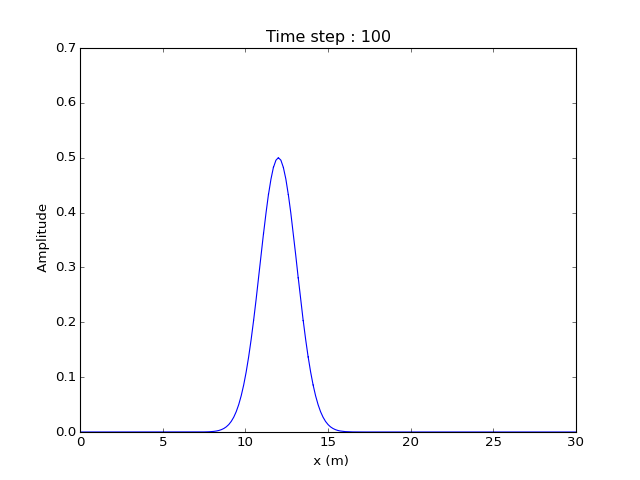

In [7]:
##------------------------------------------------------
# Initialize solution vectors
u=np.zeros(((N+1),ne))
uold = u
unew = u
uold =0.5*np.exp(-0.4*((x-15))**2) #initial condition
resu=np.zeros(((N+1),ne))

############### Time extrapolation ####################################
#
# Choose between the euler scheme and the low-storage 4-th order Runge-Kutta scheme
#
method=1 #Euler=0, RK=1

u=uold
uplot=np.reshape(u,((N+1)*ne),1)

fig = plt.figure()
line,=plt.plot(xg,uplot)
plt.ylim(0,0.7)
plt.xlabel(' x (m)')
plt.ylabel(' Amplitude ')

fig.show();
alpha=0 #upwind flux

for it in xrange(1, nt+1):
    
    if method==0: #Euler scheme
        Flux=flux(alpha,u,N,ne,mu) #calculate the flux at the boundaries of an element

        # Extrapolation for every element
        for k in range(0,ne):
               unew[:,k] = dt* (np.dot(Minv, Flux[:,k]+ np.dot(Se.T, u[:,k]))) + u[:,k]
    
        u = unew

    
    else: #RK scheme
        for INTRK in range(0,5):
            Flux = flux(alpha,u,N,ne,mu) #calculate the flux at the boundaries of an element
            rhsu = np.dot(Minv, Flux + np.dot(Se.T, u))
            resu = rk4a[INTRK]*resu + dt*rhsu
            u = u + rk4b[INTRK]*resu
                
        
    
    uplot=np.reshape(u,((N+1)*ne),1)
    line.set_ydata(uplot)
    plt.title('Time step : %g ' %it)
    fig.canvas.draw()

